In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from torch.nn import Sequential, ReLU, Module, Dropout, Sigmoid, Linear, BatchNorm2d
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Grayscale, Resize, ToTensor, Normalize
import torch.nn.functional as F
import torchvision.utils as vutils
import pickle
import os
from PIL import Image
import cv2
import json

In [21]:
%cd /home/bcca/Desktop/Soham/DL Course Project/Handwritten-Equation-Solver/

/home/bcca/Desktop/Soham/DL Course Project/Handwritten-Equation-Solver


In [22]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [23]:
batch_size = 128
transformations = Compose([Grayscale(num_output_channels=1),
                           Resize((28,28)),
                           ToTensor()])

data = ImageFolder(root='../Handwritten-Equation-Solver/data/character_data',transform=transformations)

mapping = {}
for idx, (class_name, _) in enumerate(data.class_to_idx.items()):

    if(class_name[0]=='_' and class_name[2]=='_'):
        mapping[idx] = class_name[1]
    else:
        mapping[idx] = class_name
    data.classes[idx] = idx

with open('my_dict.json', 'w') as f:
    json.dump(mapping, f)

Image size = torch.Size([128, 1, 28, 28])
Label size = torch.Size([128])


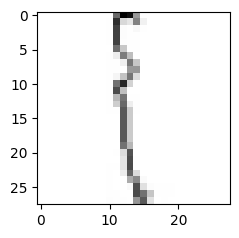

In [24]:
train_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

for i, (images, labels) in enumerate(train_loader):
    print("Image size =",images.shape)
    print("Label size =",labels.shape)
    img = images[0]
    plt.figure(figsize=(2.5,2.5))
    plt.imshow(img[0], cmap='gray')
    plt.show()
    break

In [31]:
class CharacterNet(Module):

    ''' CNN architecture for character recognition '''

    def __init__(self):

        super(CharacterNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.fc1 = nn.Linear(64 * 32 * 32, 512)
        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc2 = nn.Linear(512, 36)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # x = self.dropout(x)
        # print(x.shape)              # torch.Size([128, 64, 32, 32])
        # x = x.view(-1, 64 * 32 * 32)
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

In [32]:
model = CharacterNet().to(device)

In [34]:
num_epochs = 125
num_classes = len(data.classes)   # 107
learning_rate = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(num_epochs):

        total_correct = 0
        total_images = 0
        running_loss = 0.0

        all_predicted = []
        all_expected = []
    
        for i, (images, labels) in enumerate(train_loader):
    
            images = images.to(device)
 
            encoder = OneHotEncoder(categories=[data.classes])
            labels_encoded = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
            labels_encoded = torch.Tensor(labels_encoded).to(device)
    
            outputs = model(images)

            loss = criterion(outputs, labels_encoded)
            running_loss += loss.item()
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            _, expected = torch.max(labels_encoded, 1)
            correct = (predicted == expected).sum().item()

            all_expected.extend(list(expected.cpu().numpy()))
            all_predicted.extend(list(predicted.cpu().numpy()))
            
            total_correct += correct
            total_images += total

        acc_list.append(total_correct / total_images)
        loss_list.append(running_loss / total_step)
        
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch+1, num_epochs, (running_loss/len(train_loader)), (total_correct / total_images) * 100))

Epoch [1/125], Loss: 2.7614, Accuracy: 86.89%
Epoch [2/125], Loss: 2.7602, Accuracy: 86.87%
Epoch [3/125], Loss: 2.7529, Accuracy: 87.78%
Epoch [4/125], Loss: 2.7426, Accuracy: 88.78%
Epoch [5/125], Loss: 2.7390, Accuracy: 89.07%
Epoch [6/125], Loss: 2.7385, Accuracy: 89.21%
Epoch [7/125], Loss: 2.7372, Accuracy: 89.36%
Epoch [8/125], Loss: 2.7347, Accuracy: 89.42%
Epoch [9/125], Loss: 2.7350, Accuracy: 89.46%
Epoch [10/125], Loss: 2.7365, Accuracy: 89.25%
Epoch [11/125], Loss: 2.7347, Accuracy: 89.48%
Epoch [12/125], Loss: 2.7348, Accuracy: 89.51%
Epoch [13/125], Loss: 2.7287, Accuracy: 90.11%
Epoch [14/125], Loss: 2.7205, Accuracy: 91.03%
Epoch [15/125], Loss: 2.7154, Accuracy: 91.50%
Epoch [16/125], Loss: 2.7126, Accuracy: 91.72%
Epoch [17/125], Loss: 2.7114, Accuracy: 91.85%
Epoch [18/125], Loss: 2.7096, Accuracy: 92.04%
Epoch [19/125], Loss: 2.7087, Accuracy: 92.11%
Epoch [20/125], Loss: 2.7078, Accuracy: 92.15%
Epoch [21/125], Loss: 2.7077, Accuracy: 92.15%
Epoch [22/125], Loss: 

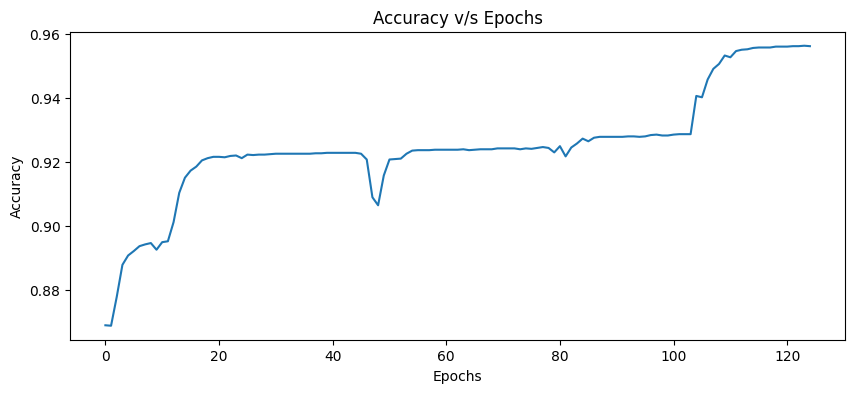

In [35]:
plt.figure(figsize=(10,4))
plt.plot(acc_list)
plt.title("Accuracy v/s Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

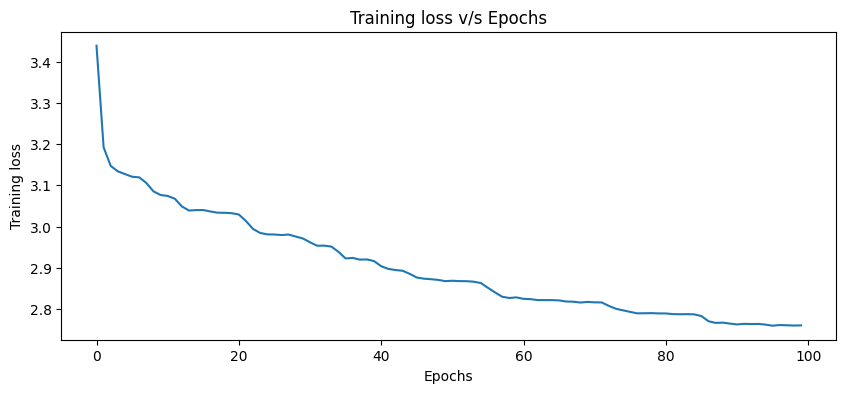

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(loss_list)
plt.title("Training loss v/s Epochs")
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

## Validation using some random image samples

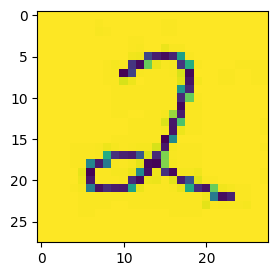

2


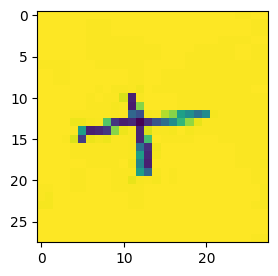

multiply


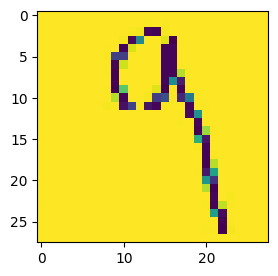

9


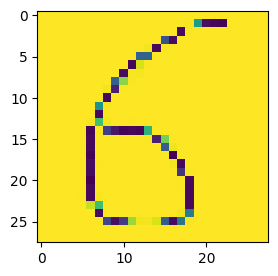

6


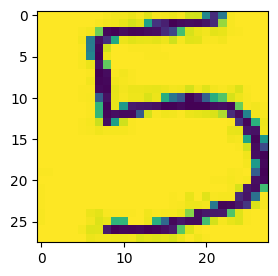

5


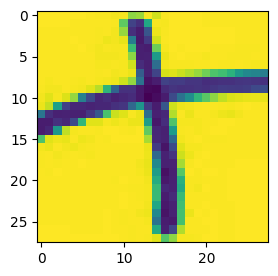

4


In [37]:
# img = Image.open('../test_data/6.jpeg').resize((128,128)).convert('L')   5 to 9

for i in range(5,7):

    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.jpeg')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (28,28))
    gray_image = gray_image.reshape((1,28,28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

for i in range(7,9):
    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/'+ str(i) + '.png')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (28,28))
    gray_image = gray_image.reshape((1,28,28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])

for i in range(9,11):
    ii = cv2.imread('../Handwritten-Equation-Solver/test_data/' + str(i)+ '.jpeg')
    gray_image = cv2.cvtColor(ii, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (28,28))
    gray_image = gray_image.reshape((1,28,28))
    data = torch.Tensor(np.array([gray_image])).to(device)
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    plt.figure(figsize=(3,3))
    plt.imshow(gray_image[0])
    plt.show()
    print(mapping[predicted.cpu().numpy()[0]])    

In [ ]:
# torch.save(model.state_dict(), 'CharacterNet.pth')

In [38]:
torch.save(model.state_dict(), 'CharacterNet2.pth')